---
title: "Forward Simulation of 3D Transient Airborne TDEM Data on a Tree Mesh"
authors:
  - id: devincowan
---

```{admonition} Intermediate notebook
:class: caution
This tutorial focusses on intermediate level functionality within SimPEG. Basic functionality within SimPEG is not discussed in detail, as we assume the user is already familiar. 
```

```{admonition} Medium-weight notebook
:class: caution
Requires moderate computational resources. Run-times may exceed several minutes and require up to 8 GB of available RAM.
```

**Keywords:** TDEM, 3D forward simulation, tree mesh.

</br>

**Summary:** In this tutorial, we present the fundamentals of simulating 3D TDEM data in SimPEG. We use the module [simpeg.electromagnetics.time_domain](xref:simpeg#simpeg.electromagnetics.time_domain) to simulate airborne TDEM data on a tree mesh. We assume the reader is already familiar with the fundamental aspects of simulating TDEM data in SimPEG, which were covered in the [Forward Simulation of Time Domain EM Data for a 1D Sounding](fwd_tdem_1d.ipynb) tutorial. This tutorial focusses on the following:

- Defining TDEM surveys for 3D simulations
- How to define an appropriate tree mesh based on problem geometry
- Defining models and mappings for simulation on a tree mesh
- Including surface topography in the simulation
- Choosing a 3D formulation that works best for the geometry of the problem
- Defining appropriate time-steps for the forward simulation

## Importing Modules

Here, we import all of the functionality required to run the notebook for the tutorial exercise. All of the functionality specific to TDEM is imported from [simpeg.electromagnetics.time_domain](xref:simpeg#simpeg.electromagnetics.time_domain). 
We also import some useful utility functions from [simpeg.utils](xref:simpeg#simpeg.utils). And to generate the mesh, we use the [discretize](https://discretize.simpeg.xyz/en/main) package.

In [1]:
# SimPEG functionality
import simpeg.electromagnetics.time_domain as tdem
from simpeg.utils import plot2Ddata
from simpeg import maps

# discretize functionality
from discretize import TreeMesh
from discretize.utils import mkvc, active_from_xyz

# Common Python functionality
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update({"font.size": 14})

save_file = False

## Defining Topography

Surface topography is defined as an (N, 3) [numpy.ndarray](xref:numpy#numpy.ndarray) for 3D simulations.
To keep things simple, we create flat topography for the forward simulation.
For user-specific simulations, you may generate less trivial topography or load topography from an XYZ file.

In [2]:
x_topo, y_topo = np.meshgrid(
    np.linspace(-3000, 3000, 101), np.linspace(-3000, 3000, 101)
)
z_topo = np.zeros(np.shape(x_topo))

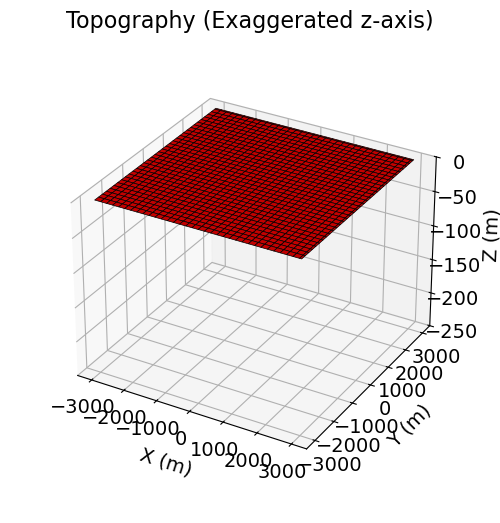

In [3]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection="3d")
ax.set_zlim([-250, 0])
ax.plot_surface(x_topo, y_topo, z_topo, color="r", edgecolor="k", linewidth=0.5)
ax.set_box_aspect(aspect=None, zoom=0.85)
ax.set_xlabel("X (m)", labelpad=10)
ax.set_ylabel("Y (m)", labelpad=10)
ax.set_zlabel("Z (m)", labelpad=10)
ax.set_title("Topography (Exaggerated z-axis)", fontsize=16, pad=-20)
ax.view_init(elev=30.0)

In [4]:
# Turn into a (N, 3) numpy.ndarray
x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)
topo_xyz = np.c_[mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)]

## Defining the Survey

The fundamentals of constructing TDEM surveys was presented in the [Forward Simulation of Time Domain EM Data for a 1D Sounding](fwd_tdem_1d.ipynb) tutorial. We advise the reader to already be familiar with this material. For a full description of all source and receiver classes, please visit API documentation for [simpeg.electromagnetics.time_domain](xref:simpeg#simpeg.electromagnetics.time_domain).

### Survey Geometry

In [5]:
# Data locations
N = 15
xloc, yloc, zloc = np.meshgrid(
    np.linspace(-175, 175, N), np.linspace(-175, 175, N), [31.0]
)
data_locations = np.c_[mkvc(xloc), mkvc(yloc), mkvc(zloc)]
n_locations = np.size(xloc)

# Source properties
loop_radius = 9.5
n_segments = 8

# Receiver properties
rx_separation = np.r_[0.0, 0.0, -10.0]
time_channels = np.logspace(-4, -2, 7)
n_times = len(time_channels)

### Defining the Waveform

In Part 3 the [Forward Simulation of 1D Time Domain EM Sounding Data](fwd_tdem_1d.ipynb) tutorial, we demonstrated how to define 

In [6]:
waveform = tdem.sources.StepOffWaveform()

Text(0.5, 1.0, 'Waveform')

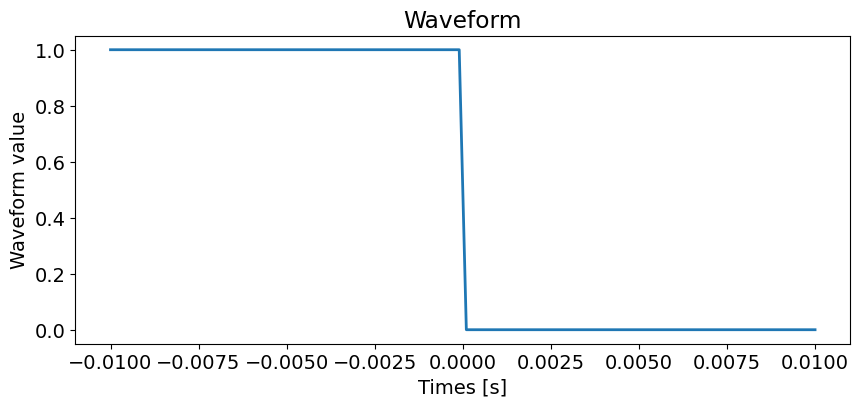

In [7]:
plot_times = np.linspace(-0.01, 0.01, 100)

# Evaluate the waveform for each on time.
waveform_value = [waveform.eval(t) for t in plot_times]

# Plot the waveform
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(111)
ax1.plot(plot_times, waveform_value, lw=2)
ax1.set_xlabel("Times [s]")
ax1.set_ylabel("Waveform value")
ax1.set_title("Waveform")

### Create Airborne Survey

In [8]:
PHI = np.linspace(0, 2 * np.pi, n_segments + 1)
xyz_loop = np.c_[
    loop_radius * np.cos(PHI), loop_radius * np.sin(PHI), np.zeros_like(PHI)
]

In [9]:
source_list = []  # Create empty list to store sources

# Each unique location defines a new transmitter
for ii in range(n_locations):
    # Here we define receivers that measure the h-field in A/m
    receivers_list = [
        tdem.receivers.PointMagneticFluxTimeDerivative(
            data_locations[ii, :] + rx_separation, time_channels, "z"
        )
    ]

    # Must define the transmitter properties and associated receivers
    source_list.append(
        tdem.sources.LineCurrent(
            receivers_list, location=xyz_loop + data_locations[ii, :], waveform=waveform
        )
    )

# Define the survey
survey = tdem.Survey(source_list)

## Designing a (Tree) Mesh for TDEM

Meshes are designed using the [discretize](https://discretize.simpeg.xyz/en/main) package. See the [discretize user tutorials](https://discretize.simpeg.xyz/en/main/tutorials/mesh_generation/index.html) to learn more about creating meshes.
Here, the forward simulation is computed for a [tree mesh](xref:discretize#discretize.TreeMesh). Because of the modular nature of SimPEG, you could define a [tensor mesh](xref:discretize#discretize.TensorMesh) instead.

### General Approach:

The primary electromagnetic fields produced by controlled sources fall off very quickly with respect to distance. For example, the primary magnetic field produced by a magnetic dipole source falls off as $r^{-3}$. Because the amplitude and direction of the primary fields varies greatly close to the source, smaller cells are needed there to model the fields accurately. Far away from the source, larger cells can be used since the fields are much smoother. Tree meshes are well-suited for TDEM simulations because the cell size can be increased at specified distances from controlled sources. For any controlled source TDEM simulation, we advise the following considerations and rules of thumb:

1. The smallest cell size used to discretize the Earth should be at most 1/2 of the diffusion distance for the earliest time channel.
2. To impose the boundary conditions properly, the padding thickness should be at least 2-3 times the diffusion distance for the latest time channel and background conductivity. You must also pad upwards into the air.
3. Successive increases in cell size should not happen too abruptly. Within your volume of interest, you should have 4 layers of cells of the same size before increasing the cell size.
4. You generally need to have several cells between the source and receiver in order to simulate the primary signal at the receiver accurately. This is less problematic when data are measured during the off-time
5. Finer discretization is required when topography is significant.

**Important:** because the diffusion distance depends on observation time and electrical conductivity, we must know something about the subsurface physical properties as well as the survey properties prior to designing our mesh.

In [10]:
# Define the base mesh
dh = 5.0  # base cell width
dom_width = 6000.0  # domain width
nbc = 2 ** int(np.round(np.log(dom_width / dh) / np.log(2.0)))  # num. base cells

h = [(dh, nbc)]
mesh = TreeMesh([h, h, h], x0="CCC", diagonal_balance=True)

# Mesh refinement based on surface topography (starting with 20 cells)
k = np.sqrt(np.sum(topo_xyz[:, 0:2] ** 2, axis=1)) < 400
mesh.refine_surface(
    topo_xyz[k, :], level=-3, padding_cells_by_level=[2, 4], finalize=False
)

# Mesh refinement near controlled sources (starting with 2.5 m cells)
pts = np.repeat(data_locations, n_segments + 1, axis=0) + np.tile(
    xyz_loop, (n_locations, 1)
)
mesh.refine_points(pts, level=-1, padding_cells_by_level=[2, 2, 2], finalize=False)

# Refine core mesh region (starting with 10 m cells)
xp, yp, zp = np.meshgrid([-280.0, 280.0], [-280.0, 280.0], [-80.0, 20.0])
box_points = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
mesh.refine_bounding_box(
    box_points, level=-2, padding_cells_by_level=[0, 4, 4, 4], finalize=False
)

# Finalize the mesh
mesh.finalize()

/tmp/ipykernel_2354303/1492772301.py:7: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  mesh = TreeMesh([h, h, h], x0="CCC")


In [11]:
print("# of cells: {}".format(mesh.n_cells))  # Number of cells
print("# of x-faces: {}".format(mesh.n_faces_x))  # Number of x-faces
print("Origin: {}".format(mesh.origin))  # bottom-southewest corner
print("Max cell volume: {}".format(mesh.cell_volumes.max()))  # Largest cell size
print(mesh.cell_centers[0:5, :])  # Cell center locations

# of cells: 131440
# of x-faces: 128936
Origin: [-2560. -2560. -2560.]
Max cell volume: 2097152000.0
[[-1920. -1920. -1920.]
 [ -960. -2240. -2240.]
 [ -320. -2240. -2240.]
 [ -960. -1600. -2240.]
 [ -320. -1600. -2240.]]


## Active Cells

Simulated geophysical data are dependent on the subsurface distribution of physical property values. As a result, the cells lying below the surface topography are commonly referred to as 'active cells'. And air cells, whose physical property values are fixed, are commonly referred to as 'inactive cells'. Here, the discretize [active_from_xyz](xref:discretize#discretize.utils.active_from_xyz) utility function is used to find the indices of the active cells using the mesh and surface topography. The output quantity is a ``bool`` array.

In [12]:
# Indices of the active mesh cells from topography (e.g. cells below surface)
ind_active = active_from_xyz(mesh, topo_xyz)
nP = np.sum(ind_active)  # number of parameters

## Models and Mapping from the Model to the Mesh

In SimPEG, the term 'model' is not necessarily synonymous with the set of physical property values defined on the mesh. For example, the model may be defined as the logarithms of the physical property values, or be the parameters defining a layered Earth geometry. Models in SimPEG are 1D [numpy.ndarray](xref:numpy#numpy.ndarray) whose lengths are
equal to the number of model parameters.

Classes within the [simpeg.maps](xref:simpeg#simpeg.maps.IdentityMap) module are used to define the mapping that connects the model to the physical property values used in the 3D FDEM simulation. Sophisticated mappings can be defined by combining multiple mapping objects. But in the simplest case, the mapping is an identity map and the model consists of the conductivity/resistivity values for all mesh cells (including air). Here, the model consists of the log-conductivity values for all active mesh cells.

When simulating 3D FDEM data, we have the choice of using resistivity or conductivity to define the Earth's electrical properties. However, one option may be implemented more naturally depending on the formulation used.

### Defining the Model

In [13]:
# Define conductivity values in S/m (or resistivity in Ohm m)
air_conductivity = 1e-8
background_conductivity = 0.01
block_conductivity = 0.1

In [14]:
# Define conductivities on active cells
active_conductivities = background_conductivity * np.ones(nP)
ind_block = (
    (mesh.cell_centers[ind_active, 0] < 80.0)
    & (mesh.cell_centers[ind_active, 0] > -80.0)
    & (mesh.cell_centers[ind_active, 1] < 80.0)
    & (mesh.cell_centers[ind_active, 1] > -80.0)
    & (mesh.cell_centers[ind_active, 2] > -120.0)
    & (mesh.cell_centers[ind_active, 2] < -30.0)
)
active_conductivities[ind_block] = block_conductivity

In [15]:
# Define the log-conductivity model
log_conductivity_model = np.log(active_conductivities)

### Defining the Mapping

Here, we use the [simpeg.maps.ExpMap](xref:simpeg#simpeg.maps.ExpMap) mapping to convert our model values from log-conductivities to conductivities, and the [simpeg.maps.InjectActiveCells](xref:simpeg#simpeg.maps.InjectActiveCells) mapping to project active cells to the entire mesh. As we will demonstrate, a single mapping can be constructed from multiple mapping classes using the $*$ operator. **Important:** When defining the active cells mapping, we set all inactive (air) cells to 1e-8 $S/m$ instead of $0$. This is done to ensure that the linear system constructed to solve the PDE for the DC resistivity problem is well-conditioned.

In [16]:
log_conductivity_map = maps.InjectActiveCells(
    mesh, ind_active, air_conductivity
) * maps.ExpMap(nP=nP)

### Plotting the discretization and active conductivities

To show the geometry of the problem, we plot the discretization near several sources and the active cell conductivities using the [plot_slice](xref:discretize#discretize.TreeMesh.plot_slice) method.

/t40array/ssoler/miniforge3/envs/simpeg-user-tutorials/lib/python3.10/site-packages/discretize/mixins/mpl_mod.py:2152: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  temp_mesh = discretize.TreeMesh(h2d, x2d)


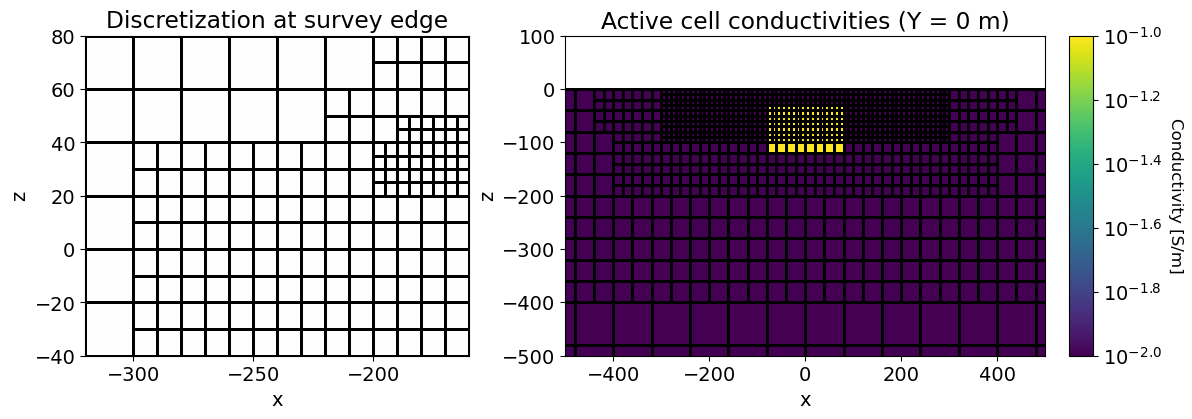

In [17]:
fig = plt.figure(figsize=(12, 4))

# Plot discretization near source
ax1 = fig.add_axes([0.05, 0.1, 0.32, 0.8])
mesh.plot_slice(
    np.zeros(mesh.nC),
    normal="Y",
    ax=ax1,
    ind=int(mesh.h[0].size / 2),
    grid=True,
    clim=[-1, 1],
    pcolor_opts={"cmap": mpl.cm.bwr},
)
ax1.set_xlim([-320, -160])
ax1.set_ylim([-40, 80])
ax1.set_title("Discretization at survey edge")

# Plot active cell conductivities
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)
log10_conductivities = np.log10(active_conductivities)
norm = mpl.colors.Normalize(
    vmin=np.log10(background_conductivity), vmax=np.log10(block_conductivity)
)

ax2 = fig.add_axes([0.45, 0.1, 0.4, 0.8])
mesh.plot_slice(
    plotting_map * log10_conductivities,
    normal="Y",
    ax=ax2,
    ind=int(mesh.h[0].size / 2),
    grid=True,
    pcolor_opts={"norm": norm},
)
ax2.set_xlim([-500, 500])
ax2.set_ylim([-500, 100])
ax2.set_title("Active cell conductivities (Y = 0 m)")

cax2 = fig.add_axes([0.87, 0.1, 0.02, 0.8])

cbar = mpl.colorbar.ColorbarBase(
    cax2, norm=norm, orientation="vertical", format="$10^{%.1f}$"
)
cbar.set_label("Conductivity [S/m]", rotation=270, labelpad=15, size=12)

## Time Stepping

In [18]:
time_steps = [(4e-6, 30), (3.2e-5, 30), (2.4e-4, 41)]

## Defining the Forward Simulation

In SimPEG, the physics of the forward simulation is defined by creating an instance of an appropriate simulation class. To fully define the forward simulation, we need to connect the simulation object to:

- the survey
- the mesh
- the mapping from the model to the mesh

This is accomplished by setting each one of the aforementioned items as a property of the simulation object. Here, we define two simulation objects, one where the model defines the subsurface conductivities, and one where the model defines subsurface log-resistivities. When our model is used to define subsurface electric conductivity, the mapping is set using the ``sigmaMap`` keyword argument. However when our model is used to define subsurface electric resistivity, the mapping must be set using the ``rhoMap`` keyword argument.

### Choosing a formulation

There are a multitude of simulation classes, each of which solves Maxwell's equations in terms of a different field:

- [Simulation3DElectricField](xref:simpeg#simpeg.electromagnetics.frequency_domain.Simulation3DElectricField), which solves for the electric fields on mesh edges.
- [Simulation3DMagneticFluxDensity](xref:simpeg#simpeg.electromagnetics.frequency_domain.Simulation3DMagneticFluxDensity), which solves for the magnetic flux density on mesh faces.
- [Simulation3DMagneticField](xref:simpeg#simpeg.electromagnetics.frequency_domain.Simulation3DMagneticField), which solves for the magnetic fields on mesh edges.
- [Simulation3DCurrentDensity](xref:simpeg#simpeg.electromagnetics.frequency_domain.Simulation3DCurrentDensity), which solves for the current density on mesh faces.

The optimum choice in simulation class depends on the fields being measured and the class used to define FDEM sources. For example, it may be best to use the electric field formulation when the source is a line-current and electric fields are being measured. And it may be best to use the magnetic field formulation for a magnetic dipole source and magnetic field measurements.

### Practical considerations

For each unique operating frequency, we need to factor the

For each source

Mesh size

In [19]:
simulation = tdem.simulation.Simulation3DElectricField(
    mesh, survey=survey, sigmaMap=log_conductivity_map
)

# Set the time-stepping for the simulation
simulation.time_steps = time_steps

In [20]:
simulation.times

array([0.000e+00, 4.000e-06, 8.000e-06, 1.200e-05, 1.600e-05, 2.000e-05,
       2.400e-05, 2.800e-05, 3.200e-05, 3.600e-05, 4.000e-05, 4.400e-05,
       4.800e-05, 5.200e-05, 5.600e-05, 6.000e-05, 6.400e-05, 6.800e-05,
       7.200e-05, 7.600e-05, 8.000e-05, 8.400e-05, 8.800e-05, 9.200e-05,
       9.600e-05, 1.000e-04, 1.040e-04, 1.080e-04, 1.120e-04, 1.160e-04,
       1.200e-04, 1.520e-04, 1.840e-04, 2.160e-04, 2.480e-04, 2.800e-04,
       3.120e-04, 3.440e-04, 3.760e-04, 4.080e-04, 4.400e-04, 4.720e-04,
       5.040e-04, 5.360e-04, 5.680e-04, 6.000e-04, 6.320e-04, 6.640e-04,
       6.960e-04, 7.280e-04, 7.600e-04, 7.920e-04, 8.240e-04, 8.560e-04,
       8.880e-04, 9.200e-04, 9.520e-04, 9.840e-04, 1.016e-03, 1.048e-03,
       1.080e-03, 1.320e-03, 1.560e-03, 1.800e-03, 2.040e-03, 2.280e-03,
       2.520e-03, 2.760e-03, 3.000e-03, 3.240e-03, 3.480e-03, 3.720e-03,
       3.960e-03, 4.200e-03, 4.440e-03, 4.680e-03, 4.920e-03, 5.160e-03,
       5.400e-03, 5.640e-03, 5.880e-03, 6.120e-03, 

## Simulating Total Field and Secondary Field Data

Once any simulation within SimPEG has been properly constructed, simulated data for a given model vector can be computed using the [dpred](xref:simpeg#simpeg.simulation.BaseSimulation.dpred) method. Note that despite the difference in how we defined the models representing the Earth's electrical properties, the data predicted by both simulations is equivalent.

In [21]:
# Predict data for a given model
dpred = simulation.dpred(log_conductivity_model)

/t40array/ssoler/miniforge3/envs/simpeg-user-tutorials/lib/python3.10/site-packages/simpeg/simulation.py:197: DefaultSolverWarning: Using the default solver: Pardiso. 

If you would like to suppress this notification, add 
warnings.filterwarnings('ignore', simpeg.utils.solver_utils.DefaultSolverWarning)
 to your script.
  return get_default_solver(warn=True)


## Plotting

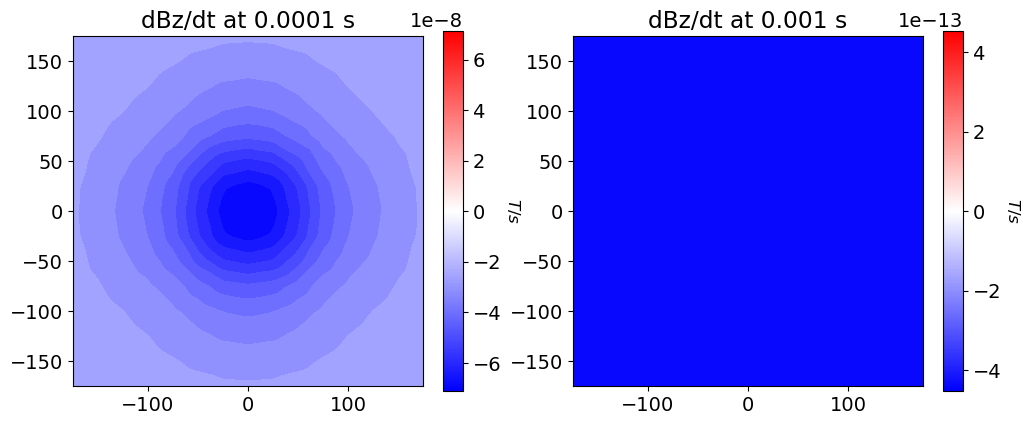

In [22]:
# Data were organized by location, then by time channel
dpred_plotting = np.reshape(dpred, (n_locations, n_times))

# Plot
fig = plt.figure(figsize=(10, 4))

# dB/dt at early time
v_max = np.max(np.abs(dpred_plotting[:, 0]))
ax11 = fig.add_axes([0.05, 0.05, 0.35, 0.9])
plot2Ddata(
    data_locations[:, 0:2],
    dpred_plotting[:, 0],
    ax=ax11,
    ncontour=30,
    clim=(-v_max, v_max),
    contourOpts={"cmap": "bwr"},
)
ax11.set_title("dBz/dt at 0.0001 s")

ax12 = fig.add_axes([0.42, 0.05, 0.02, 0.9])
norm1 = mpl.colors.Normalize(vmin=-v_max, vmax=v_max)
cbar1 = mpl.colorbar.ColorbarBase(
    ax12, norm=norm1, orientation="vertical", cmap=mpl.cm.bwr
)
cbar1.set_label("$T/s$", rotation=270, labelpad=15, size=12)

# dB/dt at later times
v_max = np.max(np.abs(dpred_plotting[:, -1]))
ax21 = fig.add_axes([0.55, 0.05, 0.35, 0.9])
plot2Ddata(
    data_locations[:, 0:2],
    dpred_plotting[:, -1],
    ax=ax21,
    ncontour=30,
    clim=(-v_max, v_max),
    contourOpts={"cmap": "bwr"},
)
ax21.set_title("dBz/dt at 0.001 s")

ax22 = fig.add_axes([0.92, 0.05, 0.02, 0.9])
norm2 = mpl.colors.Normalize(vmin=-v_max, vmax=v_max)
cbar2 = mpl.colorbar.ColorbarBase(
    ax22, norm=norm2, orientation="vertical", cmap=mpl.cm.bwr
)
cbar2.set_label("$T/s$", rotation=270, labelpad=15, size=12)

plt.show()

## Optional: Export Data

Write the true model, data and topography




In [23]:
if save_file:
    dir_path = os.path.dirname(tdem.__file__).split(os.path.sep)[:-3]
    dir_path.extend(["tutorials", "assets", "tdem"])
    dir_path = os.path.sep.join(dir_path) + os.path.sep

    fname = dir_path + "tdem_topo.txt"
    np.savetxt(fname, np.c_[topo_xyz], fmt="%.4e")

    # Write data with 2% noise added
    fname = dir_path + "tdem_data.obs"
    rng = np.random.default_rng(seed=42)
    noise = rng.uniform(low=0.0, high=0.02 * np.abs(dpred), size=len(dpred))
    dpred += noise
    t_vec = np.kron(np.ones(ntx), time_channels)
    receiver_locations = np.kron(receiver_locations, np.ones((len(time_channels), 1)))

    np.savetxt(fname, np.c_[receiver_locations, t_vec, dpred], fmt="%.4e")

    # Plot true model
    output_model = plotting_map * model
    output_model[np.isnan(output_model)] = 1e-8

    fname = dir_path + "true_model.txt"
    np.savetxt(fname, output_model, fmt="%.4e")